In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader, TensorDataset

### 1. Target Function and Data Generation
Consider some target function $f:\mathbb{R}\to\mathbb{R}$, and a compact domain $D\subset \mathbb{R}$. Let $p_x$ be the uniform distribution over $D$. We then generate data $(x,y)$ such that $x\sim p_x$ and $y=f(x)$.

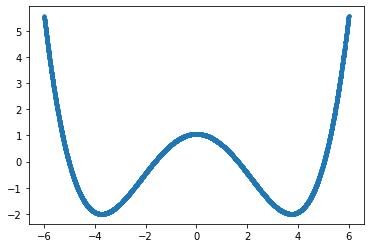

In [2]:
# DATA GENERATION

# hyperparameters
np.random.seed(0)
N = 10**4
low = -6
high = 6
params = [0.5, 0, -3.5, -0.5, 1, -3]

# define target function
def quadratic(x, _params):
    [a, b, c] = _params
    return (a*x+b)**2 + c

def target(x):
    [a1, b1, c1, a2, b2, c2] = params
    h = quadratic(x, [a1,b1,c1])
    return quadratic( h, [a2,b2,c2] ) + h

# training data
X = np.random.uniform(low, high, N)
Y = np.vectorize(target)(X)

# transform to tensor and reshape
X_tensor = torch.reshape(Tensor(X),(N,1))
y_tensor = torch.reshape(Tensor(Y),(N,1))

# visualize
plt.scatter(X, Y, marker=".")
plt.show()

Some graphical intuitions for hyperparameters:
https://www.desmos.com/calculator/pc0szofbfh.

### 2. Freeze-and-train Model (linear + quadratic + linear per layer)

In [3]:
# TRAINING
def train_model(model, X, Y, epochs, batch_size, loss_fn, optimizer):
    # load data
    dataset = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # train
    for t in range(epochs):
        for (i, (X_batch, y_batch)) in enumerate(data_loader):
            # forward
            pred = model(X_batch.float())
            loss = loss_fn(pred, y_batch)

            # backward
            optimizer.zero_grad()  # clear gradient
            loss.backward()
            optimizer.step()

        if t%10 == 0:
            print(f"\nEpoch: {t+1:n}")
            print(f"loss={loss:.3f}")
            print("_"*50)

In [4]:
# FIRST LAYER STRUCTURE

# nn.Sequential wrapper
class Lambda(nn.Module):
    """
    Input: A Function
    Returns : A Module that can be used inside nn.Sequential
    """
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): 
        return self.func(x)
    
def quad_activation(x):
    return x**2

# first_layer
class first_layer_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(1, 1),  # x -> ax+b
            Lambda(quad_activation),  # (ax+b)^2
            nn.Linear(1, 1),  # k(ax+b)^2+c
        )
    
    def forward(self, x):
        return self.sequential(x)

In [5]:
# HYPER-PARAMETERS OF TRAINING
first_layer = first_layer_model()
loss_fn = nn.MSELoss()

epochs = 50
batch_size = 64

In [6]:
# TRAIN FIRST LAYER
optim1 = optim.Adam(first_layer.parameters())
train_model(first_layer, X, Y, epochs, batch_size, loss_fn, optim1)


Epoch: 1
loss=2.126
__________________________________________________

Epoch: 11
loss=2.407
__________________________________________________

Epoch: 21
loss=2.875
__________________________________________________

Epoch: 31
loss=2.847
__________________________________________________

Epoch: 41
loss=1.341
__________________________________________________


In [7]:
# TEST MODEL
def test_model(model):
    params = []
    for p in model.parameters():
        params.append(p.item())
    print(params)

    y_pred = model(X_tensor)
    plt.scatter(X_tensor.detach().numpy(), y_pred.detach().numpy(), color="red")
    plt.scatter(X_tensor.detach().numpy(), y_tensor.detach().numpy(), color="blue", marker='.')
    plt.show()

[-0.4540213346481323, 0.027502190321683884, 0.22691059112548828, -0.6668708920478821]


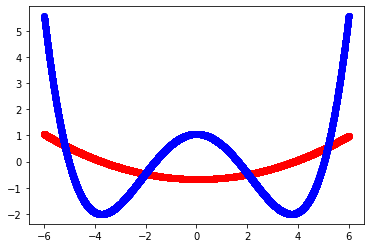

In [8]:
# FIRST LAYLER RESULT
first_layer_params = []
for p in first_layer.parameters():
    first_layer_params.append(p.item())
a1,b1,a2,b2 = first_layer_params
print(first_layer_params)

y_pred = first_layer(X_tensor)
plt.scatter(X_tensor.detach().numpy(), y_pred.detach().numpy(), color="red")
plt.scatter(X_tensor.detach().numpy(), y_tensor.detach().numpy(), color="blue")
plt.show()

In [9]:
# SECOND LAYER MODEL
def first_layer_predict(x):
    return a2*(a1*x+b1)**2 + b2

class second_layer_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            Lambda(first_layer_predict),  # predict a first layer using already trained first-layer model
            nn.Linear(1, 1),  # x -> ax+b
            Lambda(quad_activation),  # (ax+b)^2
            nn.Linear(1, 1),  # k(ax+b)^2+c
        )
    
    def forward(self, x):
        return self.sequential(x) + first_layer_predict(x)

    

In [10]:
second_layer = second_layer_model()
optim2 = optim.Adam(second_layer.parameters())
train_model(second_layer, X, Y, epochs, batch_size, loss_fn, optim2)


Epoch: 1
loss=2.546
__________________________________________________

Epoch: 11
loss=0.568
__________________________________________________

Epoch: 21
loss=0.061
__________________________________________________

Epoch: 31
loss=0.015
__________________________________________________

Epoch: 41
loss=0.013
__________________________________________________


Parameter containing:
tensor([[2.1237]], requires_grad=True)
Parameter containing:
tensor([-0.1241], requires_grad=True)
Parameter containing:
tensor([[1.5674]], requires_grad=True)
Parameter containing:
tensor([-2.0060], requires_grad=True)


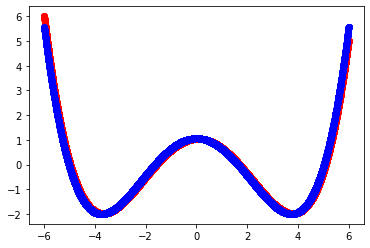

In [11]:
for p in second_layer.parameters():
    print(p)

y_pred_final = second_layer(X_tensor)
plt.scatter(X_tensor.detach().numpy(), y_pred_final.detach().numpy(), color="red")
plt.scatter(X_tensor.detach().numpy(), y_tensor.detach().numpy(), color="blue")
plt.show()

### 3. Comparison test: complete 2-layer NN
To serve as a comparison, compare the previous freeze-and-train method with the following standard structure:

In [12]:
# COMPLETE 2 LAYER NETWORK
class complete_network_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(1, 1),  # x -> ax+b
            Lambda(quad_activation),  # (ax+b)^2
            nn.Linear(1, 1),  # k(ax+b)^2+c
            Lambda(quad_activation),
            nn.Linear(1, 1),
#             Lambda(quad_activation),
#             nn.Linear(1, 1),
#             Lambda(quad_activation),
#             nn.Linear(1, 1)
        )
    
    def forward(self, x):
        return self.sequential(x)


Epoch: 1
loss=4.243
__________________________________________________

Epoch: 11
loss=0.303
__________________________________________________

Epoch: 21
loss=0.016
__________________________________________________

Epoch: 31
loss=0.000
__________________________________________________

Epoch: 41
loss=0.000
__________________________________________________
[0.4611660838127136, 1.2466796306398464e-07, 0.5949034690856934, -1.7712880373001099, 0.9761061072349548, -1.9999960660934448]


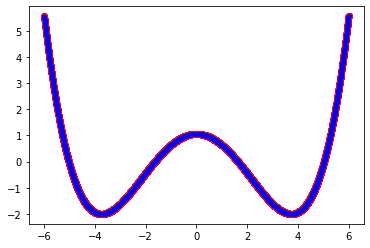

In [13]:
torch.manual_seed(12131)

_epochs = 50
complete_network = complete_network_model()
optim3 = optim.Adam(complete_network.parameters())

train_model(complete_network, X, Y, _epochs, batch_size, loss_fn, optim3)
test_model(complete_network)

#### Caveat:
The test result is somehow sensitive to initialization... I tried several standard initializatons, but all of them don't seem good...

This becomes a big issue because I don't know whether a poor fit is due to poor initialization or it is an actual counter exmample.


Epoch: 1
loss=2.746
__________________________________________________

Epoch: 11
loss=2.210
__________________________________________________

Epoch: 21
loss=4.143
__________________________________________________

Epoch: 31
loss=2.604
__________________________________________________

Epoch: 41
loss=1.814
__________________________________________________
[0.4047459065914154, -0.033154696226119995, -0.0729142278432846, 1.1152403354644775, -1.345831036567688, 1.1830036640167236]


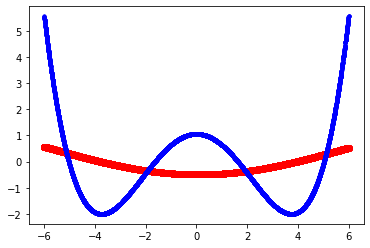

In [14]:
torch.manual_seed(1)

_epochs = 50
complete_network = complete_network_model()
optim3 = optim.Adam(complete_network.parameters())

train_model(complete_network, X, Y, _epochs, batch_size, loss_fn, optim3)
test_model(complete_network)

### 4. Freeze-and-train with linear+quadratic per layer
In order to fit a general quadratic (of form $ax^2+b$), each "layer" is actually a linear layer + quadratic activation + another linear layer (to add the constant term). Below is an attempt to see what if we only have a linear layer with a quadratic activation. Now a perfect fit is not guaranteed.

In [15]:
def black_box(model):
    _optim = optim.Adam(model.parameters())
    
    train_model(model, X, Y, epochs, batch_size, loss_fn, _optim)
    test_model(model)


Epoch: 1
loss=1.572
__________________________________________________

Epoch: 11
loss=2.952
__________________________________________________

Epoch: 21
loss=1.950
__________________________________________________

Epoch: 31
loss=2.203
__________________________________________________

Epoch: 41
loss=2.876
__________________________________________________
[-0.11843807995319366, 0.009718690067529678]


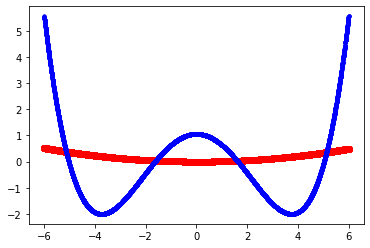

In [16]:
class first_layer_partial(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(1, 1),  # x -> ax+b
            Lambda(quad_activation),  # (ax+b)^2
        )
    
    def forward(self, x):
        return self.sequential(x)

partial_1 = first_layer_partial()
black_box(partial_1)


Epoch: 1
loss=3.087
__________________________________________________

Epoch: 11
loss=1.922
__________________________________________________

Epoch: 21
loss=2.009
__________________________________________________

Epoch: 31
loss=2.251
__________________________________________________

Epoch: 41
loss=2.015
__________________________________________________
[-0.1238870769739151, -0.0003400928108021617, 4.336422920227051, -0.7864648103713989]


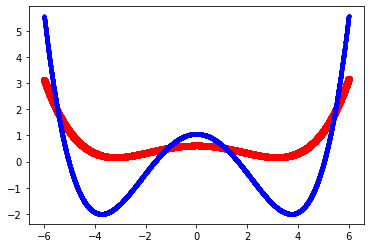

In [17]:
class second_layer_partial(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            Lambda(partial_1), 
            nn.Linear(1, 1), 
            Lambda(quad_activation),
        )
    
    def forward(self, x):
        return self.sequential(x) + partial_1(x)

partial_2 = second_layer_partial()
black_box(partial_2)


Epoch: 1
loss=4.971
__________________________________________________

Epoch: 11
loss=9.426
__________________________________________________

Epoch: 21
loss=10.314
__________________________________________________

Epoch: 31
loss=17.498
__________________________________________________

Epoch: 41
loss=4.911
__________________________________________________
[0.4627990424633026, -0.01045410055667162, -0.6291389465332031, 1.869508981704712, 0.8362515568733215, -1.8362267017364502]


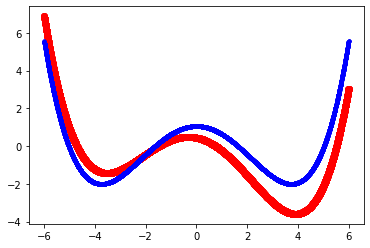

In [18]:
class complete_model_partial(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(1, 1), 
            Lambda(quad_activation),
            nn.Linear(1, 1),
            Lambda(quad_activation),
            nn.Linear(1, 1)
        )
    
    def forward(self, x):
        skip = self.sequential(x) + nn.Sequential(nn.Linear(1,1))(x)
        normal = self.sequential(x)
        return skip

partial_3 = complete_model_partial()
black_box(partial_3)

### 5. Unequal Bumps
Now we want to test another target function, which is still of W-shape, but has unequal minimums.
